# Final Project for Data Analytics

## Alyssa June Pacleb, Ravi Goparaju, Adeena Amersi, Ryan Chiapoco

In [1]:
import warnings
warnings.simplefilter("ignore")
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline

%matplotlib inline

# Science Giving Column Meanings and Types

Header | Definition | Type
---|---------|-------|
`cmte_nm` | Committee name | object
`cmte_id` | Committee identification, assigned | object
`cmte_tp` | Committee type. [List of committee type codes](https://www.fec.gov/campaign-finance-data/committee-type-code-descriptions/)  | object
<font size="5">**`cmte_pty`**</font>  | **Committee party. [List of party codes](https://www.fec.gov/campaign-finance-data/party-code-descriptions/)** | **object**
`cand_name` | Candidate name | object
`cand_pty_affiliation` | Political party affiliation reported by the candidate | object
`cand_office_st` | Candidate state | object
<font size="5">**`cand_office`**</font>  | Candidate office. H = House, P = President, S = Senate | object
`cand_office_district` | Candidate district | float64
`cand_status` | Candidate status. C = Statutory candidate, F = Statutory candidate for future election, N = Not yet a statutory candidate, P = Statutory candidate in prior cycle | object
`rpt_tp` | Report type. [Report type codes](https://www.fec.gov/campaign-finance-data/report-type-code-descriptions/) | object
<font size="5">**`transaction_pgi`**</font> | The code for which the contribution was made. EYYYY (election plus election year). P = Primary, G = General, O = Other, C = Convention, R = Runoff, S = Special, E = Recount | object
`transaction_tp` | Transaction type. [Type codes](https://www.fec.gov/campaign-finance-data/transaction-type-code-descriptions/) | object
`entity_tp` | Entity type. Only valid for electronic filings received after April 2002. CAN = Candidate, CCM = Candidate Committee, COM = Committee, IND = Individual (a person), ORG = Organization (not a committee and not a person), PAC = Political Action Committee, PTY = Party Organization | object
`cleaned_name` | Contributor/lender/transfer name | object
`city` | City/town | object
<font size="5">**`state`**</font> | State | object
`zip_code` | Zip code | object
`employer` | Employer | object
<font size="5">**`cleaned_occupation`**</font>  | Occupation | object
`classification` | Classification of occupation | object
`transaction_dt` | Transaction date (MMDDYYYY) | float64
<font size="5">**`cycle`**</font> | Election cycle | float64
`transaction_amt` | Transaction amount | float64
<font size="5">**`2016_dollars`**</font>  | Transation amount adjusted for inflation | float64
`other_id` | Other identification number. For contributions from individuals this column is null. For contributions from candidates or other committees this column will contain that contributor's FEC ID. | object
`tran_id` | Transaction ID | object
`file_num` | A unique identifier associated with each itemization or transaction appearing in an FEC electronic file. Only valid for electronic filings. | float64
`memo_cd` | 'X' indicates that the amount is not to be included in the itemization total. | object
`memo_text` | A description of the activity. | object
`sub_id` | FEC record number | float64


## Analysis and further data exploration for the neural net

In [14]:
import read

In [55]:
# importlib will reload the file 'read.py' in case you edit it outside this interpreter
import importlib
importlib.reload(read)
# gets data with some preprocessing applied, see read.py. Keep 1 column to demo some feature engineering.
copy = read.read_data(keep=['cleanedoccupation'])

In [56]:
# make sure we've loaded it correcty
print(copy.shape, copy.__sizeof__())
copy.head()

(21122, 6) 5881743


,cmte_pty,transaction_pgi,cleanedoccupation,classification,cycle,2016_dollars
15255,DEM,P,CHEMICAL ENGINEER,Engineer,2016,24.0
835971,DEM,P,OWNER/SYSTEMS ENGINEER,Engineer,2008,280.5
486692,DEM,P,CLOUD SYSTEMS ENGINEER,Engineer,2016,3.0
618071,DEM,G,ENGINEER,Engineer,2008,561.0
787438,DEM,G,ENGINEERING MANAGER,Engineer,2016,100.0


In [24]:
# utility for heatmap
import seaborn as sns
from itertools import combinations
# we will look at heatmaps for every 2 attributes, except those with too many values
def hmap(data, length=15, width=6, fixed_feature=None):
    copy = data
    if fixed_feature:
        for f2 in [f for f in copy.columns if f != fixed_feature]:
            f1 = fixed_feature
            fig, ax = plt.subplots(figsize=(length, width))
            rows, cols = f2, f1
            data = copy.groupby([f1, f2]).size().reset_index(name='counts')
            pt = data.pivot(index=rows, columns=cols, values='counts').fillna(0)
            sns.heatmap(pt, annot=False, linewidths=.5, ax=ax, cmap='BuPu',fmt='g')
        return 
    for f1, f2 in combinations(copy.columns, 2):
        l1, l2 = len(copy[f1].unique()), len(copy[f2].unique())
        if l1 < 2 or l2 < 2: continue
        if l1 * l2 > 500 or l1 * l2 < 4: continue
        # fig, ax = plt.subplots(figsize=(max(l1, l2), min(l1, l2)))
        fig, ax = plt.subplots(figsize=(length, width))
        rows, cols = f2, f1
        if l1 > l2:
            rows, cols = f1, f2
        # reset_index flattens a hierarchical index
        data = copy.groupby([f1, f2]).size().reset_index(name='counts')
        pt = data.pivot(index=rows, columns=cols, values='counts').fillna(0)
        sns.heatmap(pt, annot=False, linewidths=.5, ax=ax, cmap='BuPu',fmt='g')

#### Let's plot heatmaps of some of the covariates and see if there's anything that stands out...

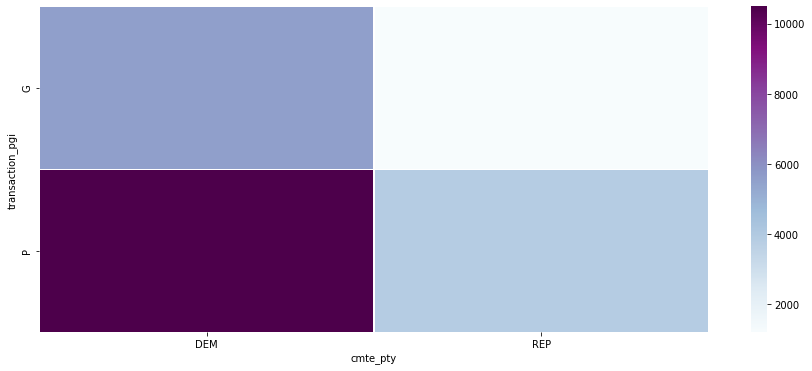

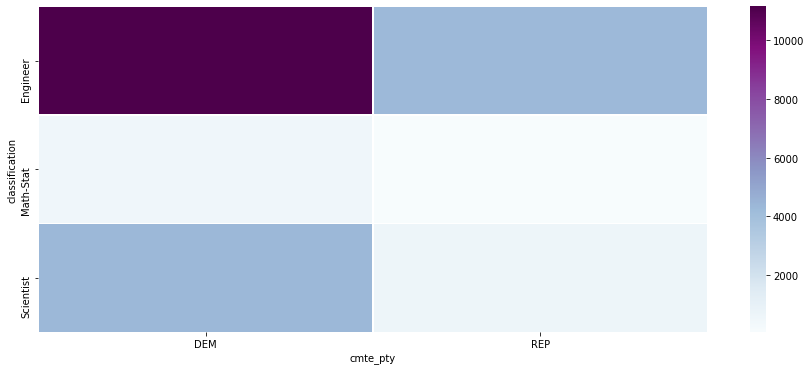

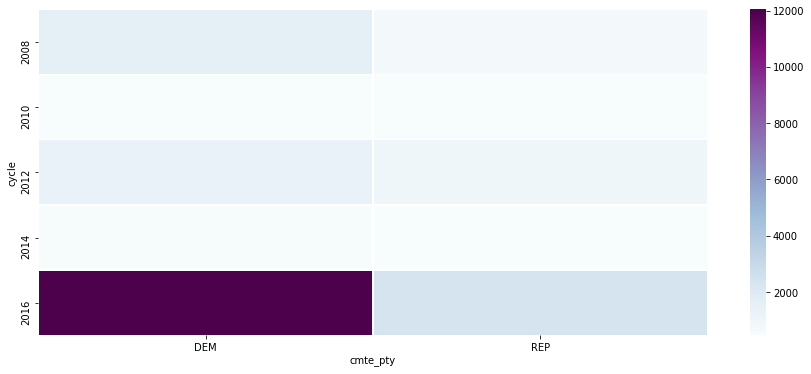

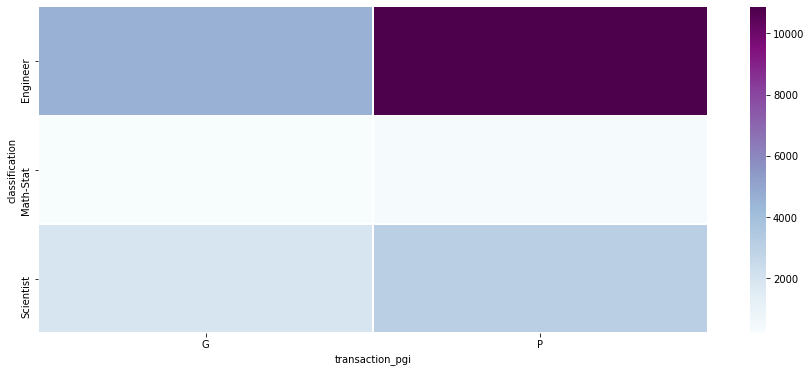

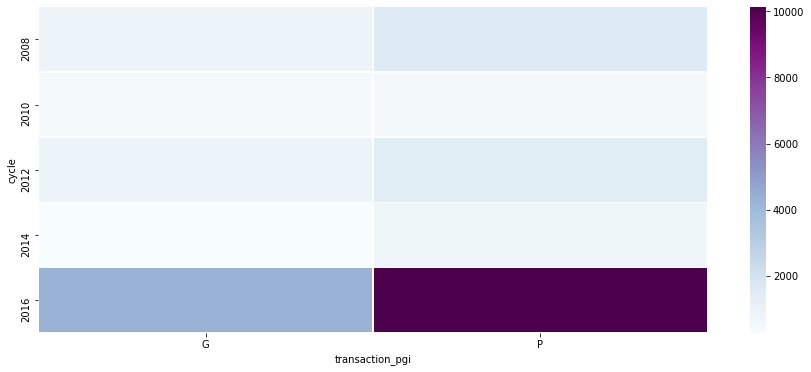

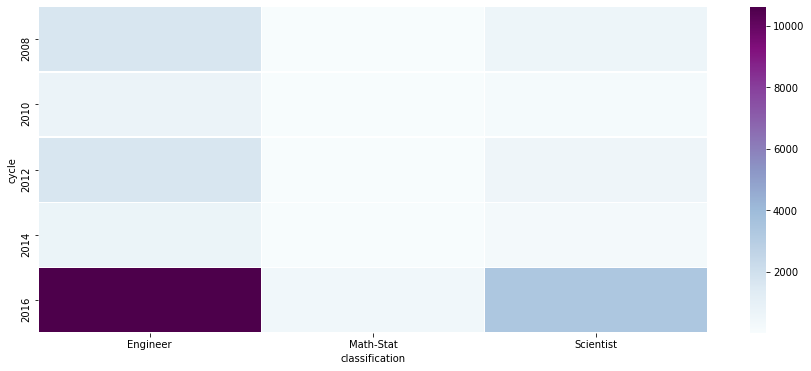

In [25]:
hmap(copy)

##### Like we saw in `Actual_final_project.ipynb`, the data includes records with donors predominantly Democratic, giving during presidential cycles, and Engineers. 

##### We analyze the distribution of the only numeric predictor, 2016_dollars, to determine an appropriate scaling or binning for the neural net.

range: -5225.0, 10450.0


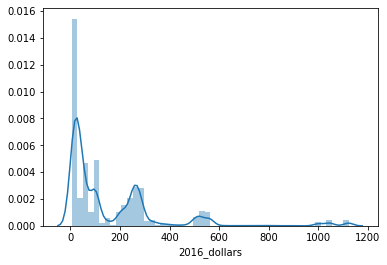

In [46]:
print('range: {}, {}'.format(copy['2016_dollars'].min(), copy['2016_dollars'].max()))
# get the 2.5 and 97.5 percentiles
low, high = copy['2016_dollars'].quantile(.025), copy['2016_dollars'].quantile(.975)
sns.distplot(copy[copy['2016_dollars'].between(low, high)]['2016_dollars'])

We see here that using a scaling mapping everything into [0,1] would compress all inliers into a small range with outliers farther out, so this would make it easier for the neural net to determine whether someone contributed a lot of money or not. On the other hand there are some people in the middle contributing modest amounts ($250-1000), so perhaps the usual z-score standardization could work; also there are negative values indicating refunds.

Let's bin this continuous predictor and make heatmaps with respect to the other predictors to see if there's anything that stands out.

744371        (0, 175]
732130      (400, 600]
673927      (175, 400]
520289        (0, 175]
724486        (0, 175]
              ...     
817103    (1000, 1200]
828878        (0, 175]
813162      (175, 400]
880267      (400, 600]
666141      (175, 400]
Name: 2016_dollars, Length: 21122, dtype: category
Categories (7, interval[int64]): [(-5225, 0] < (0, 175] < (175, 400] < (400, 600] < (600, 1000] < (1000, 1200] < (1200, 11000]]


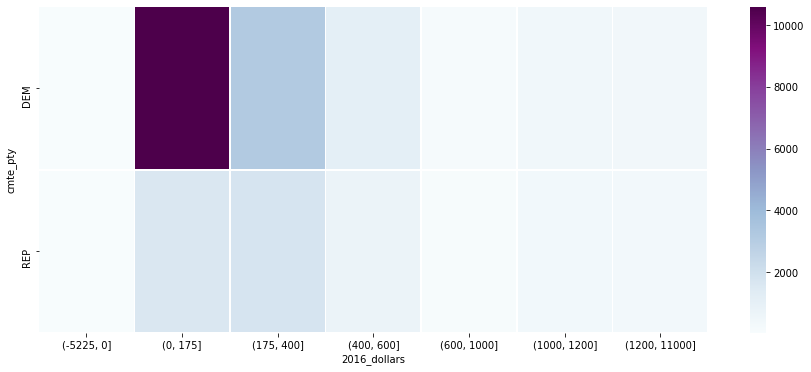

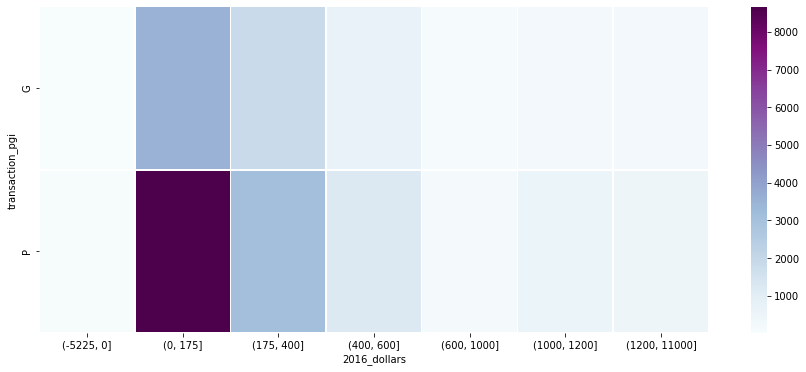

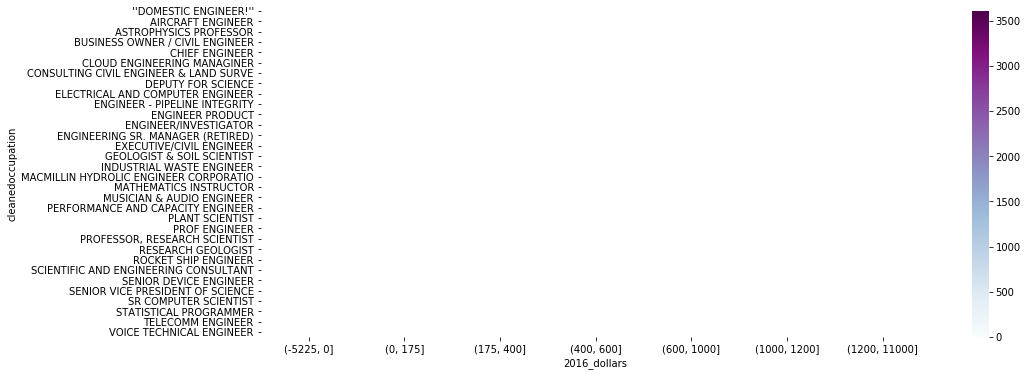

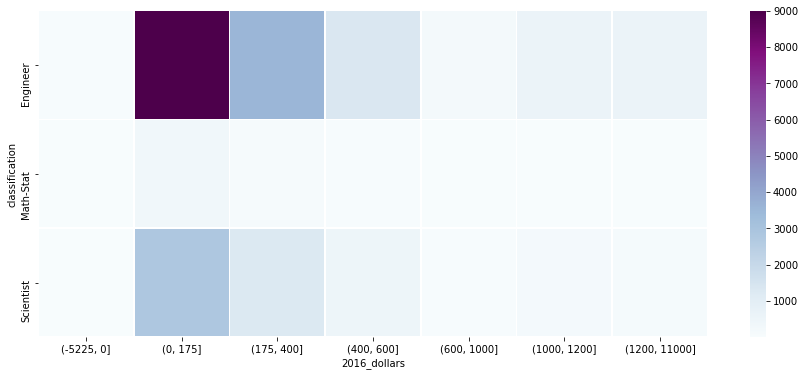

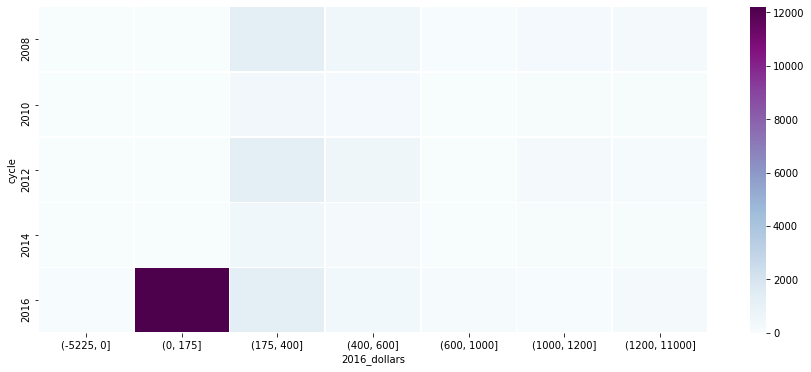

In [26]:
# bin it with respect to other features: the distribution suggests this binning
# values less than 0, [0, 175], [175, 400], [400, 600], [600, 8000], [1000, 1200], [1200+]
bins = pd.cut(copy.copy()['2016_dollars'], bins=[-5225, 0, 175, 400, 600, 1000, 1200, 11000])
print(bins)
binned = copy.assign(**{'2016_dollars': bins})
hmap(binned, fixed_feature='2016_dollars')

In [36]:
# module that estimates mutual information between a predictor and target
import bestfeatures

## Feature engineering for MLP classifier

### First task: reduce the number of unique values in the cleanedoccupation column
This will make the one-hot-encoding sklearn.neural_network.MLPClassifier() does under the hood result in a not-too-wide design matrix and keep training times reasonable.

In [96]:
# working copy
df = copy.copy()

In [58]:
# initial feature importance
importlib.reload(bestfeatures)
bestfeatures.best_features(df)

X shape:  (21122, 5)
Y shape:  (21122,)
X_train =  (16897, 5)  y_train =  (16897,)
X_test =  (4225, 5)  y_test =  (4225,)
Feature transaction_pgi: 0.004004
Feature cleanedoccupation: 0.071504
Feature classification: 0.003767
Feature cycle: 0.037848
Feature 2016_dollars: 0.105922


#### Let's look at the counts for the cleanedoccupation column. 
- As we can see there are 1752 unique occupations listed. As a starting point, let's attempt to rename each occupation with one of the top 30 in terms of counts.

In [59]:
df['cleanedoccupation'].value_counts()

ENGINEER                              6975
ENGINEER (SOFTWARE)                   3103
SCIENTIST                             1551
CIVIL ENGINEER                         446
GEOLOGIST                              380
                                      ... 
CIVIL LIBERTIES ENGINEER                 1
DIRECTOR OF ENGINEERING & RESEARCH       1
UNIVERSITY PROFESSOR / SCIENTIST         1
AUTOMATION & CONTROLS ENGINEER           1
PUBLIC HEALTH ENGINEER                   1
Name: cleanedoccupation, Length: 1752, dtype: int64

#### Let's relabel and fix some of these; it will be important in the feature engineering to come.

In [97]:
labels = [
    ('ENGINEER - SALES', 'SALES ENGINEER'),
    ('(CHEMIST)', 'CHEMIST'),
    ('ENGINEER MECHANICAL', 'MECHANICAL ENGINEER'),
    ('DIRECTOR ENGINEERING', 'ENGINEERING DIRECTOR'),
    ('ENGINEER NETWORK', 'NETWORK ENGINEER'),
    ('ENGINEER (SOFTWARE)', 'SOFTWARE ENGINEER'),
    ('ENVIRONMENTAL /SCIENTIST', 'ENVIRONMENTAL SCIENTIST'),
    ('ENGINEER SYSTEMS', 'SYSTEMS ENGINEER'),
    ('SYSTEM ENGINEER', 'SYSTEMS ENGINEER'),
    ('GEO PHYSICIST', 'PHYSICIST'),
    ('ENGINEERING', 'GENERAL ENGINEER'),
    ('ENGINEER', 'GENERAL ENGINEER'),
    ('ENGINEER - ENVIRONMENTAL', 'ENVIRONMENTAL ENGINEER'),
    ('RESEARCH SCIENTIST', 'SCIENTIST'),
    # sifting through df['cleanedoccupation'].unique() some more, here are some others we can fix,
    ('PROFESSOR & SCIENTIST', 'PROFESSOR'),
    ('ENGINEER STRUCTURAL', 'STRUCTURAL ENGINEER'),
    ('S.W. ENGINEER', 'SOFTWARE ENGINEER'),
    ('ENGINEER PETROLEUM', 'PETROLEUM ENGINEER')
]
labels = dict(labels)

df['cleanedoccupation'] = df['cleanedoccupation'].replace(labels)

#for incorrect, correct in labels:
    #df.loc[df['cleanedoccupation'] == incorrect, 'cleanedoccupation'] = correct
    
# update working copy
# copy = df.copy()

#### Let's get the top 30 occupations in terms of counts...

In [98]:
valid_cts = df['cleanedoccupation'].value_counts().sort_values(ascending=False)[:30]
cutoff = valid_cts[-1]
valid_occs = set(valid_cts.index)
print('cutoff:', cutoff)
print('total number of records:', valid_cts.sum())
print(valid_occs)

cutoff: 47
total number of records: 16171
{'CIVIL ENGINEER', 'GEOLOGIST', 'MATH TEACHER', 'DATA SCIENTIST', 'PETROLEUM ENGINEER', 'SYSTEMS ENGINEER', 'NETWORK ENGINEER', 'ELECTRICAL ENGINEER', 'GENERAL ENGINEER', 'CHEMIST', 'ENGINEERING MANAGER', 'CONSULTING ENGINEER', 'SCIENTIST', 'BIO-CHEMIST', 'DESIGN ENGINEER', 'PHYSICIAN & SCIENTIST', 'STRUCTURAL ENGINEER', 'MECHANICAL ENGINEER', 'ENVIRONMENTAL SCIENTIST', 'SOFTWARE ENGINEER', 'MATHEMATICIAN', 'COMPUTER SCIENTIST', 'AEROSPACE ENGINEER', 'SALES ENGINEER', 'COMPUTER ENGINEER', 'PHYSICIST', 'CHEMICAL ENGINEER', 'STATISTICIAN', 'ENVIRONMENTAL ENGINEER', 'MEDICAL PHYSICIST'}


- Here we attempt a naive tokenization of the data: the idea is, given a occupation value that is not in the top 30, we tokenize it using `str.split(c)` for every non-alphanumeric character `c` occuring in the dataset, and compare that with a tokenization of each occupation the top 30. 
- We count how many times a token of a non-common occupation is a subset of a token of a common occupation, and transform the non-common occupation to the 'main' occupation that maximizes this token overlap. No overlaps will be assigned the occupation 'OTHER'.

In [99]:
# occupations corpus
occ_corpus = df.loc[~df['cleanedoccupation'].isin(valid_occs), 'cleanedoccupation'].unique()
# get the nonalphanums
chars = set()
for sent in occ_corpus:
    nonalphas = [c for c in sent if not(c.isalnum())]
    chars.update(nonalphas)
    
# attempt to split on all non-alpha chars, get tokens, count how many match the tokens in each of 
# the top 30 occupations that made the cutoff. 'valid_occs' are the top 30.
replace = {}
i = 1
for occ in occ_corpus:
    current_best = 0
    best_pred_occ = 'OTHER'
    for v in valid_occs:
        num_overlaps = 0
        for c in chars:
            tokens, vtokens = occ.split(c), v.split(c)
            num_overlaps += sum([1/(len(tokens)) for t in tokens if t in vtokens])
            num_overlaps += sum([1/(len(vtokens)) for t in vtokens if t in tokens])
            # num_overlaps += sum([1/(len(tokens)) for t in tokens if any([t in _ for _ in vtokens])])
            # num_overlaps += sum([1/(len(vtokens)) for t in vtokens if any([t in _ for _ in tokens])])
        if num_overlaps > current_best:
            current_best = num_overlaps
            best_pred_occ = v
            
    replace[occ] = best_pred_occ
    if i % 100 == 0: print(f'Example: Occupation {occ} is predicted to be {best_pred_occ}')
    i += 1
    
df['cleanedoccupation'] = df['cleanedoccupation'].replace(replace)
# figure out improvement to feature importance
bestfeatures.best_features(df)

Example: Occupation ENGINEER PROJECT is predicted to be CIVIL ENGINEER
Example: Occupation ENGINEER/BUSINESS is predicted to be OTHER
Example: Occupation ASSOCIATE CHEMIST is predicted to be CHEMIST
Example: Occupation HEALTH SCIENTIST ADMINISTRATOR is predicted to be SCIENTIST
Example: Occupation CONFIGURATION SW ENGINEER is predicted to be CIVIL ENGINEER
Example: Occupation CHEMICAL ENGINEERING PROFESSOR is predicted to be ENGINEERING MANAGER
Example: Occupation PHYSICIAN, CHEMIST, PUBLIC HEALTH is predicted to be OTHER
Example: Occupation GRADUATE TEACHING ASSISTANT MATHEMATIC is predicted to be OTHER
Example: Occupation SOFT ENGINEER is predicted to be CIVIL ENGINEER
Example: Occupation USER INTERFACE ENGINEER is predicted to be CIVIL ENGINEER
Example: Occupation QUALITY & RELIABILITY ENGINEER is predicted to be CIVIL ENGINEER
Example: Occupation PD/ENGINEER is predicted to be OTHER
Example: Occupation CHAIR OF ARTS AND SCIENCES PUBLIC POLI is predicted to be OTHER
Example: Occupat

In [81]:
# reset
df = copy.copy()

- Here we attempt the same but now use a proven Natural Language Processing technique, namely by using the cosine similarity (instead of just counting overlapping tokens) of a top 30 occupation with the other occupations on their TF-IDF vectors, the corpus being the set of all unique values in the 'cleanedoccupation' column.
- TF-IDF encodes each occupation as a $p$-dimensional vector, with each dimension corresponding to a unique 'token' gotten by tokenizing each element of the corpus, and the entries being the counts of that token, weighted by how frequently the appear overall in the corpus

In [78]:
# experimental: try with tfidf + cosine similarity
# again, we are attempting to relabel entries in the cleanedoccupation column 
# with 1 of the 30 or so most common values 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

occs = np.sort(df['cleanedoccupation'].unique())
malformed = np.sort(df.loc[~df['cleanedoccupation'].isin(valid_occs), 'cleanedoccupation'].unique())
valid = np.sort(df.loc[df['cleanedoccupation'].isin(valid_occs), 'cleanedoccupation'].unique())

vectorizer = TfidfVectorizer()
corp = vectorizer.fit_transform(occs).todense()
# rows: occ, cols: tfidf scores on the parsed tokens/terms
replace = {}
num_others = 0
i = 0
for occ in malformed:
    X = vectorizer.transform(valid)
    y = vectorizer.transform([occ])
    sims = cosine_similarity(X, Y=y).flatten()
    # if we can't match a non-top 30 to any of the top 30 well, just give it the label 'OTHER'
    other_cutoff = 0.0125
    best_pred_idx = np.argmax(sims)
    if np.max(sims) > other_cutoff:
        pred = valid[best_pred_idx]
    else:
        pred = 'OTHER'
        num_others += 1
    replace[occ] = pred
    if i % 100 == 0: print(f'Example: Occupation {occ} is predicted to be {pred}')
    i += 1
print(f'Unable to classify: {num_others}')

# write the predictions to preview them
# with open('./preds.txt', 'a+') as fi:
    # fi.write(f'{occ} predicted: {pred}\n'
    
df['cleanedoccupation'] = df['cleanedoccupation'].replace(replace)

Example: Occupation ''DOMESTIC ENGINEER!'' is predicted to be AEROSPACE ENGINEER
Example: Occupation ASSOCIATE SECURITY ENGINEER is predicted to be AEROSPACE ENGINEER
Example: Occupation CHEMISTRY TECH SPECIALIST is predicted to be OTHER
Example: Occupation CONSULTANT - PETROLEUM ENGINEER is predicted to be AEROSPACE ENGINEER
Example: Occupation DIRECTOR OF SOFTWARE ENGINEERING, S&D is predicted to be ENGINEERING MANAGER
Example: Occupation ENGINEER / ESTIMATOR is predicted to be AEROSPACE ENGINEER
Example: Occupation ENGINEERING ADMINISTRATOR is predicted to be ENGINEERING MANAGER
Example: Occupation FACULTY--ENGINEERING is predicted to be ENGINEERING MANAGER
Example: Occupation HOUSEHOLD ENGINEER is predicted to be AEROSPACE ENGINEER
Example: Occupation MATH is predicted to be OTHER
Example: Occupation NOC ENGINEER is predicted to be AEROSPACE ENGINEER
Example: Occupation PHYSICS TEACHER is predicted to be OTHER
Example: Occupation PROFESSOR OF MECHANICAL AND AEROSPACE is predicted t

In [80]:
bestfeatures.best_features(df)
# what if we just delete the 'OTHER' records?
print('\n')
bestfeatures.best_features(df[df['cleanedoccupation'] != 'OTHER'])

X shape:  (21122, 5)
Y shape:  (21122,)
X_train =  (16897, 5)  y_train =  (16897,)
X_test =  (4225, 5)  y_test =  (4225,)
Feature transaction_pgi: 0.004004
Feature cleanedoccupation: 0.025813
Feature classification: 0.003767
Feature cycle: 0.037848
Feature 2016_dollars: 0.105922


X shape:  (20253, 5)
Y shape:  (20253,)
X_train =  (16202, 5)  y_train =  (16202,)
X_test =  (4051, 5)  y_test =  (4051,)
Feature transaction_pgi: 0.000000
Feature cleanedoccupation: 0.028271
Feature classification: 0.010298
Feature cycle: 0.042190
Feature 2016_dollars: 0.102598


#### The naive algorithm edges out the TF-IDF stuff, so we use that. 
- The new engineered 'cleanedoccupation' column has lower mutual info than before, but it is still higher than 'classification', and has a reasonable amount of categories compared to the original 'cleanedoccupation' column, so we replace both.

#### Let's plot heatmaps of this newly engineered column versus the other predictors to see if we can uncover any other patterns that may have not been there before.

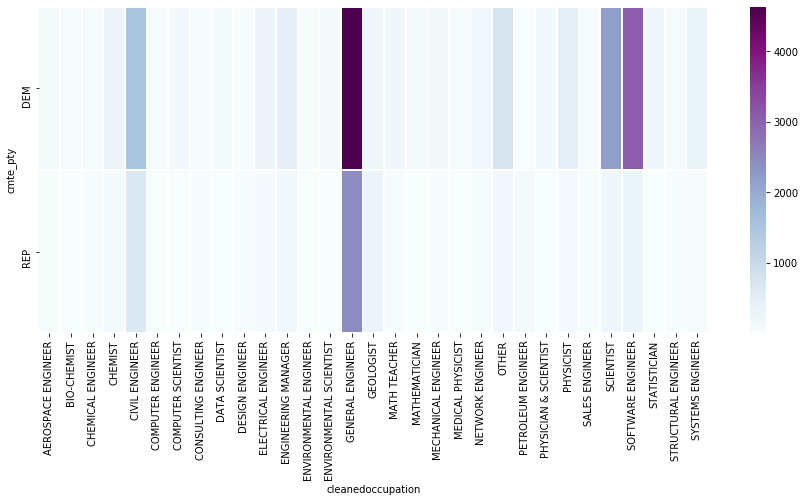

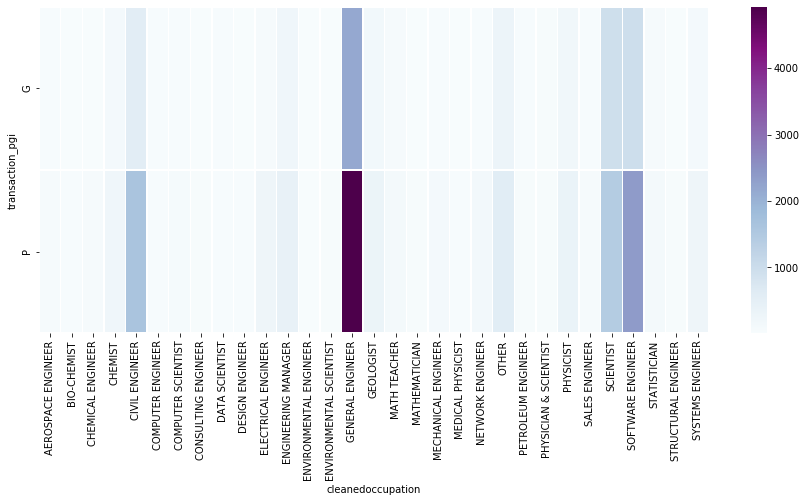

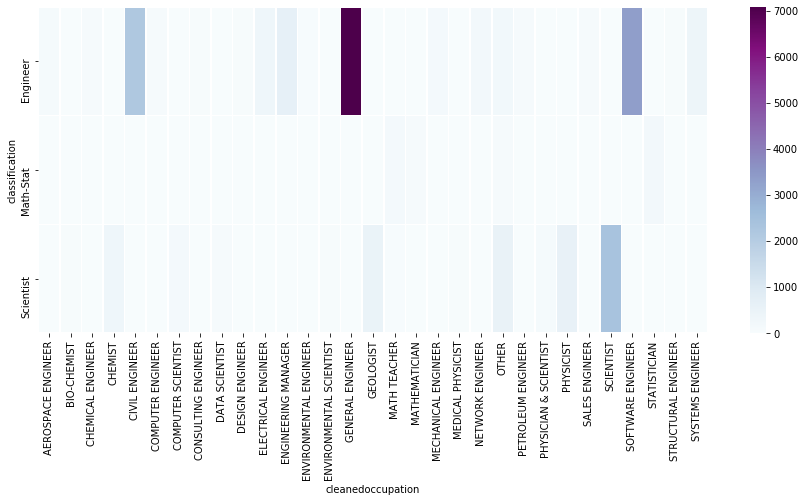

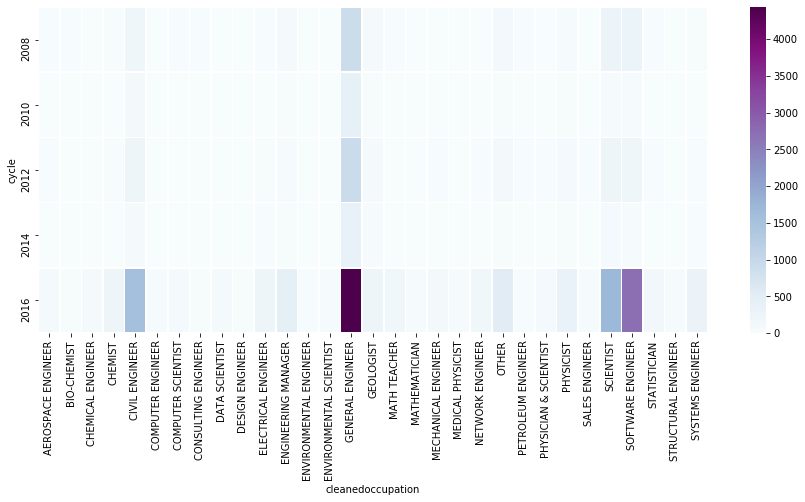

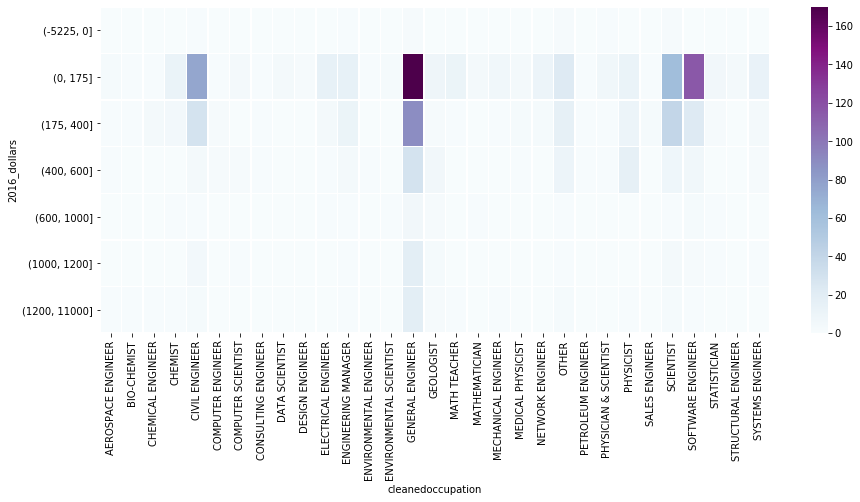

In [100]:
# replot the heatmap
hmap(df.assign(**{'2016_dollars':bins}), fixed_feature='cleanedoccupation')

#### There are no obvious patterns we can see through these colormaps, although with some less naive data exploration, one could certainly do better.

NOTE TO SELF: Re-execute the cells for the tokenization to make those changes stick past this point!

In [75]:
# Can we do some sort of clustering on the employer column?

## Model selection and evaluation

### Simpler model first: (multinomial) logistic regression 

This generalized linear model has the form
$$\log(\text{Pr}(Y = k)) = \beta x^\top - \log Z$$
for classes $k$ and predictors $i$. $Z$ normalizes the predicted probabilities so they sum to 1. We need to find the coefficients $\beta$. (Solving for $Y$ gives the softmax activation function.)

In [116]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, make_scorer

covariates = df.copy()
_X = OneHotEncoder().fit_transform(covariates.drop(labels=['2016_dollars', 'cmte_pty'], axis=1)).todense()
X = np.concatenate((_X, covariates[['2016_dollars']].to_numpy()), axis=1)
y = covariates[['cmte_pty']]
y = LabelEncoder().fit_transform(y)
glm = LogisticRegression(multi_class='multinomial')

# regularization
params = {
    'C': np.logspace(-4, 4, num=2),
    'penalty': ('l1', 'l2')
}

In [117]:
cross_val_score(
    GridSearchCV(glm, param_grid=params, scoring=make_scorer(f1_score)), 
    X, y=y, cv=5, scoring=make_scorer(f1_score))
# pretty bad.

array([0.34740484, 0.37355147, 0.35661017, 0.36718225, 0.36174636])

## ...Now a neural network

#### Now we train the net, encoding all categorical features 1-hot, and converting the DataFrames into their numpy array base representations.

In [134]:
from sklearn.compose import ColumnTransformer

covariates = df.copy()
_X = OneHotEncoder().fit_transform(covariates.drop(labels=['2016_dollars', 'cmte_pty'], axis=1)).todense()
X = np.concatenate((_X, covariates[['2016_dollars']].to_numpy()), axis=1)
y = covariates[['cmte_pty']]
y = LabelEncoder().fit_transform(y)

mlp = MLPClassifier()

# define the transforms: use Column transformer to only scale the last column of the training/validation data.
scale_floats = ColumnTransformer([
    ('scale', StandardScaler(), X.shape[1]-1)
], remainder='passthrough')
params = {
    'ffnet__activation': ('relu', 'tanh'),
    'ffnet__hidden_layer_sizes': [(25, 25), (50, ), (20, 20, 10)]
}
pipeline = Pipeline(steps=[('scaler', scale_floats), ('ffnet', mlp)])

In [135]:
# Train and assess accuracy. Use all cores!!
import os
n = os.cpu_count()
gscv = GridSearchCV(pipeline, param_grid=params, cv=5, verbose=2, n_jobs=n-1, scoring=make_scorer(f1_score))
cvs = cross_val_score(gscv, X, y=y, cv=5, verbose=2, scoring=make_scorer(f1_score))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


[CV]  ................................................................
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=3)]: Done  30 out of  30 | elapsed:  3.1min finished


[CV] ................................................. , total= 3.3min
[CV]  ................................................................
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.3min remaining:    0.0s
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  30 out of  30 | elapsed:  2.9min finished


[CV] ................................................. , total= 3.2min
[CV]  ................................................................
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  30 out of  30 | elapsed:  3.0min finished


[CV] ................................................. , total= 3.3min
[CV]  ................................................................
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  30 out of  30 | elapsed:  2.8min finished


[CV] ................................................. , total= 3.1min
[CV]  ................................................................
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  30 out of  30 | elapsed:  2.9min finished


[CV] ................................................. , total= 3.2min


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 16.0min finished


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
print(f'f1 score: {cvs.mean():.3f}')
final_model = gscv.best_estimator_.fit(X, y)
yhat = final_model.predict(X)

In [155]:
# the f1-score is much higher when trained and evaluated on the whole dataset
# NOTE: 0 == DEM, 1 == REP
print(classification_report(y, yhat))
print(f'Reported f1: {cvs.mean():.3f}')

              precision    recall  f1-score   support

           0       0.84      0.91      0.87     16060
           1       0.61      0.44      0.51      5062

    accuracy                           0.80     21122
   macro avg       0.73      0.68      0.69     21122
weighted avg       0.78      0.80      0.79     21122

Reported f1: 0.446


#### 0.446 f1-score using a feed-forward neural net, an improvement over the logistic model
- 5-5 fold cv, optimized for relu or tanh activation in the inner folds, and hidden layers of (50,50), 100, (35, 35, 35). Optimal parameters chosen using f1-score.
- Training a deeper model would almost certainly increase the f1-score, but this would take more compute resources so we don't do it for our whole dataset. We tried using 200 nodes in the hidden layers in various topologies, with improvements to (cross-validated) 0.46-0.5, although this was done on a very small training/validation set.